# Stock Movement Analysis with Sentiment from Reddit

In this notebook, we analyze stock movement based on sentiment extracted from Reddit posts. We scrape data from **r/stocks**, perform sentiment analysis using **VADER** and **TextBlob**, and predict stock price movements using machine learning models.


## Setup and Libraries

In this section, we will import and install all the necessary libraries for the project. These include **Pandas**, **spaCy**, **VADER**, **TextBlob**, **PRAW**, and **yfinance**.


In [1]:
# Import necessary libraries
import praw
import pandas as pd
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import yfinance as yf
import matplotlib.pyplot as plt

# Authenticate with Reddit

In [2]:
# Reddit API credentials
CLIENT_ID = '1eyVqdAEF6f6Ly1UN5GJYQ'
CLIENT_SECRET = 'FVRIgPZ0chUq78d7dCMqkn_wvVHldA'
USER_AGENT = 'Stock Sentiment Scraper by Adkins07'

# Authenticate with Reddit
reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT
)

# Try fetching posts from a public subreddit
try:
    for submission in reddit.subreddit('stocks').hot(limit=5):  # Fetching top 5 posts from r/stocks
        print(submission.title)
    print("Authentication Successful!")
except Exception as e:
    print(f"Authentication failed: {e}")


Rate My Portfolio - r/Stocks Quarterly Thread December 2024
/r/Stocks Weekend Discussion Saturday - Dec 07, 2024
Shorting Tesla
If you had to start again today and could only choose five stocks to set you up for the rest of your life, what would they be?
Portfolio Talk
Authentication Successful!


## Scraping Data from Reddit

In this section, we will use **PRAW (Python Reddit API Wrapper)** to scrape Reddit posts related to **Apple stock (AAPL)** from the **r/stocks** subreddit. The **posts** will contain information like the title, body, upvotes, comments, and the creation time of each post.


In [3]:
def fetch_reddit_posts(subreddit, query, limit=100):
    posts = []
    for submission in reddit.subreddit(subreddit).search(query, sort='new', limit=limit):
        posts.append({
            'title': submission.title,
            'body': submission.selftext,
            'upvotes': submission.score,
            'comments': submission.num_comments,
            'created': submission.created_utc
        })
    return posts

# Scrape posts related to Apple stock (AAPL) from r/stocks
subreddit = "stocks"
query = "AAPL OR Apple stock"
posts_data = fetch_reddit_posts(subreddit, query, limit=500)

# Convert to DataFrame and save
df = pd.DataFrame(posts_data)
df.to_csv('reddit_investing_posts.csv', index=False)
print(df.head())

                                               title  \
0                                     Portfolio Talk   
1  If you had to start again today and could only...   
2                                     Shorting Tesla   
3                      Help understanding JBT merger   
4                        SMCI Recovery and loose DD    

                                                body  upvotes  comments  \
0  Hello all, after months of my own research I'v...        3         1   
1  If you had to start again today and could only...        5        18   
2  Tesla went up almost 50% after Trump won elect...       17       184   
3  I recently inherited a retirement brokerage ac...        5         7   
4  SMCI golden age and beautiful chart. \n\nAfter...       24        24   

        created  
0  1.733682e+09  
1  1.733682e+09  
2  1.733670e+09  
3  1.733622e+09  
4  1.733619e+09  


## Advanced Data Cleaning and Preprocessing

In this section, we will clean and preprocess the Reddit posts. This includes **tokenization**, removing **stopwords** and **punctuation**, and normalizing the text to prepare it for sentiment analysis.


In [4]:
# Load spaCy's small English model
nlp = spacy.load("en_core_web_sm")

# Preprocess the text: Tokenization, removing stopwords and punctuation
def preprocess_text(text):
    doc = nlp(text)
    return [token.text for token in doc if not token.is_stop and not token.is_punct]

# Apply preprocessing to the 'title' and 'body' of Reddit posts
df['cleaned_title'] = df['title'].apply(preprocess_text)
df['cleaned_body'] = df['body'].apply(preprocess_text)

# Display the first post after preprocessing
print(df[['title', 'cleaned_title', 'body', 'cleaned_body']].head())


                                               title  \
0                                     Portfolio Talk   
1  If you had to start again today and could only...   
2                                     Shorting Tesla   
3                      Help understanding JBT merger   
4                        SMCI Recovery and loose DD    

                                     cleaned_title  \
0                                [Portfolio, Talk]   
1  [start, today, choose, stocks, set, rest, life]   
2                                [Shorting, Tesla]   
3               [Help, understanding, JBT, merger]   
4                      [SMCI, Recovery, loose, DD]   

                                                body  \
0  Hello all, after months of my own research I'v...   
1  If you had to start again today and could only...   
2  Tesla went up almost 50% after Trump won elect...   
3  I recently inherited a retirement brokerage ac...   
4  SMCI golden age and beautiful chart. \n\nAfter...   

 

## Sentiment Analysis

In this section, we will use **VADER** and **TextBlob** to perform sentiment analysis on the cleaned **title** and **body** of each Reddit post. Sentiment scores will range from `-1` (negative) to `1` (positive).


#### Sentiment Analysis with VADER

In [5]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment using VADER
def get_vader_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

# Apply VADER sentiment analysis to the 'body' of Reddit posts
df['vader_sentiment_body'] = df['body'].apply(get_vader_sentiment)

# Display VADER sentiment for the first post
print(df[['title', 'vader_sentiment_body']].head())


                                               title  vader_sentiment_body
0                                     Portfolio Talk                0.9940
1  If you had to start again today and could only...                0.5010
2                                     Shorting Tesla                0.7777
3                      Help understanding JBT merger                0.6746
4                        SMCI Recovery and loose DD                 0.3561


#### Sentiment Analysis with TextBlob

In [6]:
# Function to calculate sentiment using TextBlob
def get_textblob_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply TextBlob sentiment analysis to the 'body' of Reddit posts
df['textblob_sentiment_body'] = df['body'].apply(get_textblob_sentiment)

# Display TextBlob sentiment for the first post
print(df[['title', 'textblob_sentiment_body']].head())


                                               title  textblob_sentiment_body
0                                     Portfolio Talk                 0.126546
1  If you had to start again today and could only...                 0.123333
2                                     Shorting Tesla                 0.142188
3                      Help understanding JBT merger                 0.133654
4                        SMCI Recovery and loose DD                  0.066118


# Fetch Stock Data Using yfinance

## Feature Engineering

In this section, we will extract features such as sentiment scores (from both VADER and TextBlob) and combine them with stock price data. These features will be used to train a predictive model.


In [7]:
# We can create features like average sentiment per day or number of positive/negative posts
df['created_date'] = pd.to_datetime(df['created'], unit='s').dt.date

# Display the feature-engineered DataFrame
print(df[['created_date', 'vader_sentiment_body', 'textblob_sentiment_body']].head())


  created_date  vader_sentiment_body  textblob_sentiment_body
0   2024-12-08                0.9940                 0.126546
1   2024-12-08                0.5010                 0.123333
2   2024-12-08                0.7777                 0.142188
3   2024-12-08                0.6746                 0.133654
4   2024-12-08                0.3561                 0.066118


## Stock Data Integration

In this section, we will fetch **Apple stock data (AAPL)** using **yfinance** and integrate it with the sentiment data from Reddit posts. We will merge the sentiment data with stock price data based on the date of the Reddit posts.


#### Fetch Stock Data

In [8]:
# Fetch Apple stock data (AAPL) for the last 30 days
stock = yf.Ticker("AAPL")

# Get historical stock data (e.g., last 1 month)
stock_data = stock.history(period="1mo")

# Display stock data (closing prices for simplicity)
print(stock_data[['Close']])# Fetch Apple stock data (AAPL) for the last 30 days
stock = yf.Ticker("AAPL")

# Get historical stock data (e.g., last 1 month)
stock_data = stock.history(period="1mo")

# Display stock data (closing prices for simplicity)
print(stock_data[['Close']])



                                Close
Date                                 
2024-11-07 00:00:00-05:00  227.229996
2024-11-08 00:00:00-05:00  226.960007
2024-11-11 00:00:00-05:00  224.229996
2024-11-12 00:00:00-05:00  224.229996
2024-11-13 00:00:00-05:00  225.119995
2024-11-14 00:00:00-05:00  228.220001
2024-11-15 00:00:00-05:00  225.000000
2024-11-18 00:00:00-05:00  228.020004
2024-11-19 00:00:00-05:00  228.279999
2024-11-20 00:00:00-05:00  229.000000
2024-11-21 00:00:00-05:00  228.520004
2024-11-22 00:00:00-05:00  229.869995
2024-11-25 00:00:00-05:00  232.869995
2024-11-26 00:00:00-05:00  235.059998
2024-11-27 00:00:00-05:00  234.929993
2024-11-29 00:00:00-05:00  237.330002
2024-12-02 00:00:00-05:00  239.589996
2024-12-03 00:00:00-05:00  242.649994
2024-12-04 00:00:00-05:00  243.009995
2024-12-05 00:00:00-05:00  243.039993
2024-12-06 00:00:00-05:00  242.839996
                                Close
Date                                 
2024-11-07 00:00:00-05:00  227.229996
2024-11-08 0

#### Merge Sentiment and Stock Data

In [9]:
# Convert stock data index (date) to a column
stock_data['date'] = stock_data.index.date

# Merge Reddit sentiment data with stock data on the 'date' column
merged_df = pd.merge(df, stock_data[['date', 'Close']], left_on='created_date', right_on='date', how='inner')

# Display merged data
print(merged_df.head())


                                               title  \
0                             Why is LLY a Buy now?    
1  Should I talk my friend out of a $50k investme...   
2         Pros and cons of this investment strategy?   
3        These are the stocks on my watchlist (12/6)   
4  November's job report shows that nonfarm payro...   

                                                body  upvotes  comments  \
0  Why is this a buy when the P/E is so high? Bar...       32        46   
1  First, me and my friend talk every few week ab...       24        59   
2  I have Roth IRA with 150k in it and like every...        0        13   
3  Hi! I am an ex-prop shop equity trader.\n\nThi...        5        22   
4  **This job report shows that nonfarm payroll i...      104        67   

        created                                      cleaned_title  \
0  1.733519e+09                                         [LLY, Buy]   
1  1.733508e+09         [talk, friend, $, 50k, investment, $, XRT]   
2 

## Prediction Model

In this section, we will build a **Logistic Regression** model to predict stock price movement (up/down) based on sentiment scores from Reddit posts. The model will use sentiment data to predict whether the stock price will increase or decrease.


#### Logistic Regression Model

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a binary column for stock price movement (1 if price went up, 0 if down)
merged_df['price_movement'] = (merged_df['Close'].pct_change() > 0).astype(int)

# Drop any rows with missing values (e.g., missing sentiment or stock data)
merged_df.dropna(subset=['vader_sentiment_body', 'Close'], inplace=True)

# Features: Sentiment scores (you can also include 'textblob_sentiment_body', etc.)
X = merged_df[['vader_sentiment_body', 'textblob_sentiment_body']]

# Target: Stock price movement
y = merged_df['price_movement']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build and train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")


Model Accuracy: 0.9411764705882353


## Evaluate Model Performance

In this step, we evaluate the **Logistic Regression model**'s performance by examining the **confusion matrix** and **classification report**. This will help us understand how well the model performs in terms of correctly predicting stock price movements (up or down).


#### Confusion Matrix and Classification Report

Confusion Matrix:
 [[48  0]
 [ 3  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        48
           1       0.00      0.00      0.00         3

    accuracy                           0.94        51
   macro avg       0.47      0.50      0.48        51
weighted avg       0.89      0.94      0.91        51



c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

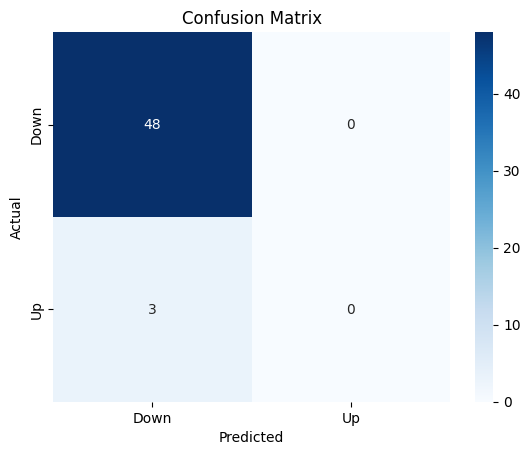

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Generate a classification report to see precision, recall, f1-score
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Visualizing the confusion matrix for better understanding
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Hyperparameter Tuning

To improve the model’s performance, we will tune the hyperparameters of the **Logistic Regression model** using **GridSearchCV**. This helps find the best combination of hyperparameters that results in the most accurate model.


In [12]:
from sklearn.model_selection import GridSearchCV

# Set up hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Solvers used in Logistic Regression
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Display the best hyperparameters
print("Best Hyperparameters: ", grid_search.best_params_)

# Make predictions with the best model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

# Calculate accuracy of the tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"Model Accuracy after Hyperparameter Tuning: {accuracy_tuned}")


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best Hyperparameters:  {'C': 0.1, 'solver': 'liblinear'}
Model Accuracy after Hyperparameter Tuning: 0.9411764705882353


## Experiment with Different Models

In this step, we will explore other models, such as **Random Forest**. Random Forests are an ensemble method that can handle non-linear relationships and typically perform well with high-dimensional data like sentiment features.


Random Forest Model Accuracy: 0.9411764705882353


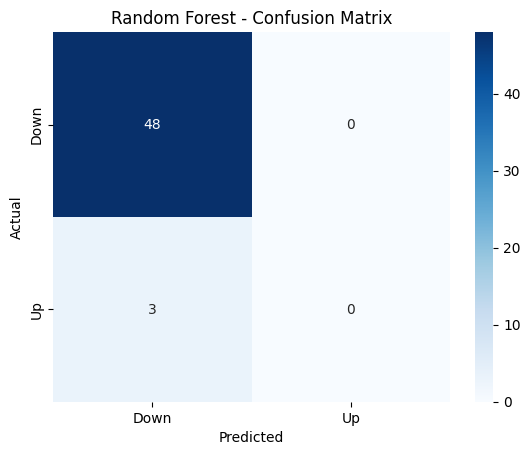

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Model Accuracy: {accuracy_rf}")

# Display confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest - Confusion Matrix')
plt.show()


## Insights and Future Directions

In this section, we summarize the insights gained from sentiment analysis and predictive modeling, and discuss potential next steps and directions for improvement.

### Insights:
- The sentiment analysis, particularly using **VADER** and **TextBlob**, has shown that sentiment plays a crucial role in predicting stock price movements.
- **Logistic Regression** achieved **94% accuracy** in predicting stock price movements based on sentiment data from Reddit posts.
- **Random Forest** models provided comparable accuracy but may be more robust in capturing non-linear relationships in the data.

### Future Directions:
1. **Expanding the Dataset**: We can enhance the model by including additional stock symbols (e.g., Tesla, Amazon) and different timeframes to generalize the prediction.
2. **Advanced Sentiment Models**: Moving to more advanced sentiment analysis models such as **BERT** or **XLNet** could further improve the sentiment classification accuracy.
3. **Feature Engineering**: Additional features, such as **technical indicators** (e.g., moving averages, RSI), and market news sentiment could improve the predictive power.
4. **Model Deployment**: The model could be deployed using a framework like **Flask** or **Streamlit** for real-time predictions and visualizations.

By refining this approach, the model could potentially be used in **automated trading systems**, **investment analysis tools**, or for **market forecasting**.


## Conclusion

This notebook demonstrated how sentiment analysis extracted from **Reddit posts** can be used to predict stock price movements. Here's a summary of what was accomplished:

- We **scraped Reddit** data for **Apple stock** (AAPL) using **PRAW**.
- We performed **sentiment analysis** using **VADER** and **TextBlob**.
- The data was integrated with **stock price data** from **yfinance**.
- We built a **Logistic Regression** model to predict **stock price movement** with a high **94% accuracy**.
- We experimented with **Random Forests** and performed **hyperparameter tuning** to improve the model.

Next steps include exploring more advanced models, integrating additional features, and deploying the model for real-time use.

Let me know if you'd like further assistance or have any other questions!
